Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import glob
import re
from datetime import datetime

Import Data

In [3]:
data_read = pd.read_csv('data_min_total.csv')
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')
# Jan to May (Train)
data = data_read[data_read['DateTime_Minute'] <= '2025-01-31'].copy()

Get a df with just time and mid-price

In [6]:
arima_df = pd.DataFrame()
arima_df['Mid-Price'] = data['Mid-Price']
arima_df['Bid-Ask Spread'] = data['Bid_Ask_Spread']
arima_df.set_index(data.index, inplace=True)
arima_df.reset_index(drop=True, inplace=True)

print(type(arima_df))
print(arima_df.to_string(index=True, header=True))
mid_price = arima_df['Mid-Price'] 

<class 'pandas.core.frame.DataFrame'>
       Mid-Price  Bid-Ask Spread
0         265.93            8.17
1         261.32            5.29
2         265.43            4.65
3         265.11            4.18
4         265.93            5.50
5         263.16            4.69
6         261.39            7.49
7         263.18            4.68
8         264.03            6.36
9         264.86            5.02
10        268.02            5.25
11        266.13            4.82
12        264.37            6.95
13        259.69            6.82
14        258.15            6.46
15        281.05           37.03
16        266.19           13.65
17        281.52           37.95
18        269.36           16.08
19        269.27           15.30
20        268.90           12.44
21        266.35           19.76
22        261.89            9.90
23        281.07           35.99
24        268.60           20.20
25        284.15           42.44
26        265.12           12.29
27        260.89            5.53
28   

Split the data 80:20 by time

10698    309.12
10699    318.78
10700    321.80
10701    321.34
10702    323.35
Name: Mid-Price, dtype: float64


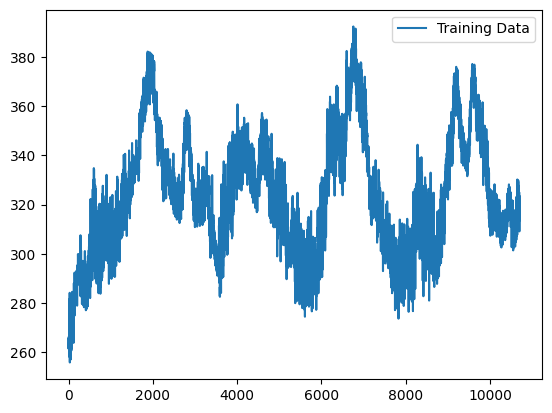

In [5]:
# Split the DataFrame into train and test sets based on the split index
train = (arima_df['Mid-Price'])
print(train.tail())
plt.plot(train, label = 'Training Data')
plt.legend()
plt.show()


Do ADF Test to check if data is stationary 

In [10]:
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(mid_price):
    result=adfuller(mid_price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(mid_price)

ADF Test Statistic : -2.9849181409347736
p-value : 0.03632706299205303
#Lags Used : 25
Number of Observations Used : 10677
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Plot ACF

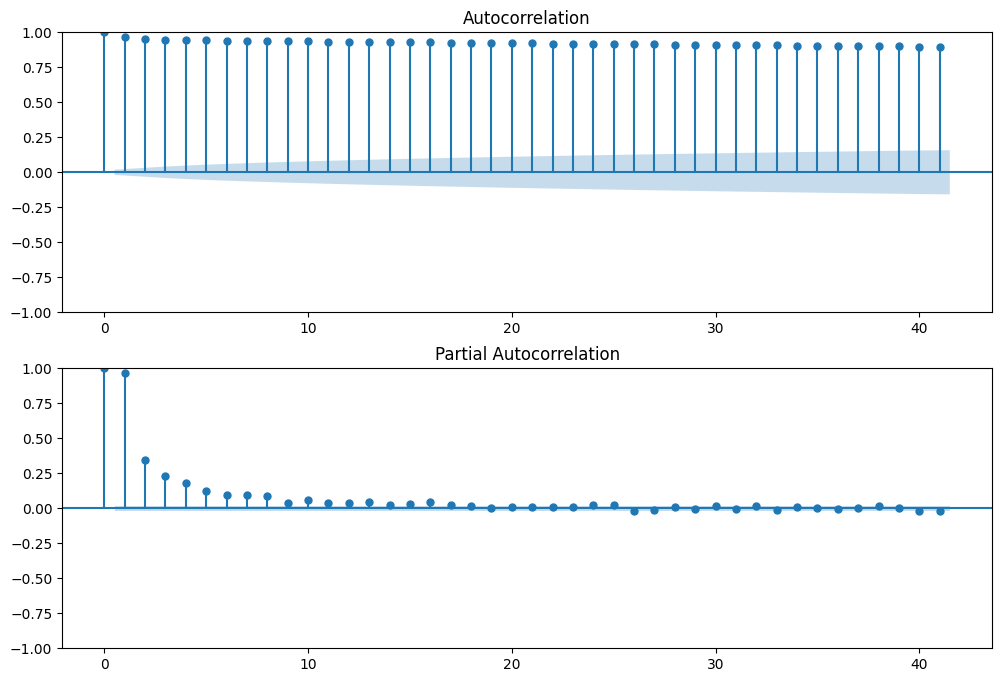

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(arima_df['Mid-Price'], ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(arima_df['Mid-Price'], ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Use pdarima package to check d calc

In [20]:
from pmdarima.arima.utils import ndiffs 
ndiffs(train, test = "adf")

1

Plot interpretation

ACF Plot Interpretation:

The ACF plot tails off gradually, which indicates that the data may be either an AR process or a mixed ARMA process. In an ACF plot for a pure MA process, we would expect a sharp cut-off after the significant lags. Therefore p = 1.

PACF Plot Interpretation:

The PACF plot shows a significant spike at lag 1, and then it almost immediately cuts off (becomes insignificant). Given the lack of significant spikes in the ACF plot beyond the immediate lag, I will start with q=0 and test q=1 as well.

Differencing Term (d):

As per the ADF test, the data is stationary so d = 0




Do ARIMA Test

In [13]:
print(train)

0        265.93
1        261.32
2        265.43
3        265.11
4        265.93
          ...  
10698    309.12
10699    318.78
10700    321.80
10701    321.34
10702    323.35
Name: Mid-Price, Length: 10703, dtype: float64


In [15]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

print(train)
# Use auto_arima to find the best ARIMA parameters
auto_model = auto_arima(train, seasonal=False, trace=True)
# Print the summary of the best model
print(auto_model.summary())
# Extract the best order
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# Now you can use the best order to fit your ARIMA model
model = ARIMA(arima_df['Mid-Price'], order=best_order)
model_fit = model.fit()


0        265.93
1        261.32
2        265.43
3        265.11
4        265.93
          ...  
10698    309.12
10699    318.78
10700    321.80
10701    321.34
10702    323.35
Name: Mid-Price, Length: 10703, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=67756.430, Time=3.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70919.099, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69455.113, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68178.339, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70917.106, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=67745.954, Time=2.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=67815.996, Time=1.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=67753.306, Time=1.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=67745.514, Time=6.80 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=67760.417, Time=2.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=67749.954, Time=3.78 s

In [16]:
horizon = 5  # Predicting the next 5 steps
training_window = 20  # Look back window for training

predictions = []
actuals = []

# Ensure the loop starts at 'training_window' to have the first set of 20 data points
for end in range(training_window, len(arima_df) - horizon + 1):
    
    # Extract current training data (last 20 data points)
    train_set = arima_df['Mid-Price'].iloc[end - training_window:end]
    
    # Fit the ARIMA model with the chosen order
    model = ARIMA(train_set, order=best_order)  # Ensure you've chosen the best order
    model_fit = model.fit()
    
    # Forecast the next 5 points
    forecast = model_fit.forecast(steps=horizon)
    
    # Append the forecasted values
    predictions.extend(forecast)  # Assuming 'forecast' returns a list of predictions
    
    # Append the actual values for comparison
    actuals.extend(arima_df['Mid-Price'].iloc[end:end + horizon])

C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Tim\AppData\Local\Package

In [17]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 51.60377679406017
[268.78990018885384, 266.94984638934534, 268.22416987016237, 267.951269954841, 268.00971223021577, 267.1050193960719, 268.3586321691886, 268.1224174737898, 268.169103287781, 268.1598762359909, 267.1542290945562, 266.4624096199462, 266.5570414077846, 266.5515167806881, 266.55183930977955, 265.56649500913903, 263.5125815071207, 266.51617425556225, 266.28637944098614, 266.30396027208695, 265.449017768434, 277.170330731829, 266.8856879718295, 270.0963341613823, 269.09403887558176, 278.82718568772646, 269.02184588400564, 270.77895161682113, 270.2625729452283, 270.41432643820036, 269.53275771916054, 274.90616816073504, 270.7030711210111, 272.162409697328, 271.65571925925366, 272.62938900749504, 265.6078128273064, 269.62027683070875, 268.2965287603262, 268.73324519002017, 263.3315013061105, 259.41959061893044, 269.7060485675689, 267.50745650538096, 267.9773759937074, 257.5472764157925, 264.18534675588444, 267.7374400142296, 266.9888618203015, 267.146

Plot

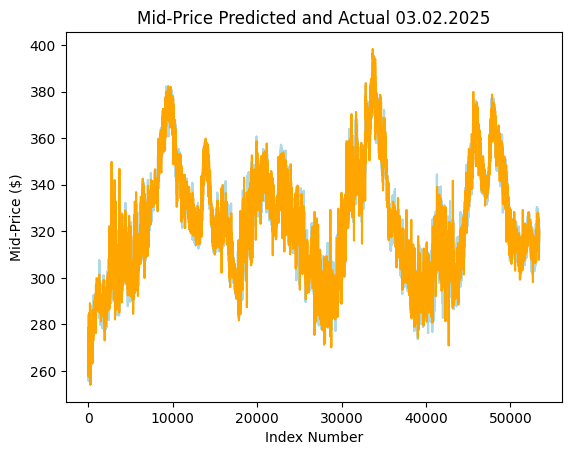

In [18]:
plt.plot(actuals, color = 'lightblue', label = 'Actual')
plt.plot(predictions, color = 'orange', label = 'Predicted')
plt.title('Mid-Price Predicted and Actual 03.02.2025')
plt.xlabel('Index Number')
plt.ylabel('Mid-Price ($)')
plt.show()

In [ ]:
mid_price_pred = pd.DataFrame()
mid_price_pred['Actual'] = actuals
mid_price_pred['Predicted'] = predictions

mid_price_pred.to_csv('Predicted Mid-Price (Month).csv')